In [ ]:
import pandas as pd
import sklearn
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
import os
from os.path import join
os.listdir("/kaggle/input/ds-nlp")

input_dir = "/kaggle/input/"
output_dir = "/kaggle/working/"

dataset_path = join(input_dir, "ds-nlp/.___DS_NLP.xlsx")

In [ ]:
df = pd.read_excel(dataset_path)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Классический ML

## Токенизация

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer

#Токенизируем наши данные (в качестве токенов будут выступать отдельные слова)
def tokenize(data):
    tokens = pd.Series()
    tokenizer = RegexpTokenizer(r'\w+')
    for i, review in enumerate(data):
        for sent in sent_tokenize(review, 'russian'):
            tokens.loc[i] = tokenizer.tokenize(sent)
    nonempty_ind = tokens.str.len() != 0
    tokens = tokens[tokens.str.len() != 0]
    tokens = tokens.reset_index().drop('index', axis=1)
    tokens = tokens.rename({0: 'review'}, axis=1)
    return tokens, nonempty_ind

tokens, nonempty_ind = tokenize(df.text)
df = df[nonempty_ind]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

#Отчистим токены от стоп-слов, которые только мешают обучению
def filter_tokens(tokens):
    filtered_tokens = pd.Series()
    for i, review in enumerate(tokens.review):
        filtered_tokens.loc[i] = [word for word in review if word not in stopwords.words('russian')]
    filter_tokens = pd.DataFrame(filtered_tokens)
    filter_tokens.rename({0: 'review'}, axis=1, inplace=True)
    return filter_tokens

tokens = filter_tokens(tokens)
tokens

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review
0,"[перестаньте, впаривать, клиентам, дополнитель..."
1,"[это, очень, приятно]"
2,"[продавец, режил, продать, нам, товар, почему,..."
3,"[навязанные, услуги, моего, согласия, сумму, 1..."
4,"[оператор, проигнорировала, информацию, ошибке..."
...,...
2714,[спасибо]
2715,"[продавцы, торопятся, заказами, разговаривают,..."
2716,"[профессионализма, менеджеру, внимания, клиент..."
2717,"[сколько, времени, ещё, стояла, просто, ждала,..."


Продолжим преобразование токенов. Объединим в токен те словосочетания из двух слов, которые встречаются как минимум 20 среди всех отзывов.

In [ ]:
from nltk.collocations import *

def get_text(tokens):
    text = ''
    for i in range(len(tokens)):
        text += ' '.join(tokens[i])
    text = text.strip()
    return text

#Для начала найдём эти словосочетания
bigram_measures = nltk.collocations.BigramAssocMeasures()
text = get_text(tokens.review)
finder = BigramCollocationFinder.from_words(word_tokenize(text))
freq_filter = 20
finder.apply_freq_filter(freq_filter)
nbest = 100
most_common_phrases = finder.nbest(bigram_measures.raw_freq, nbest)

In [ ]:
from nltk.tokenize import MWETokenizer

#Объединим их в один токен
def tokenize(tokens):
    tokenizer = MWETokenizer()
    for phrase in most_common_phrases:
        tokenizer.add_mwe(phrase)
    for i, review in enumerate(tokens):
        tokens.loc[i] = tokenizer.tokenize(review)
    tokens = pd.DataFrame(tokens)
    tokens = tokens.rename({0: 'review'}, axis=1)
    return tokens

tokens = tokenize(tokens.review)

In [ ]:
!pip install pymorphy2
import pymorphy2

#Лемматизируем токены:
def lemmatize(tokens):
    morph = pymorphy2.MorphAnalyzer(lang='ru')
    new_tokens = pd.Series()
    for i, review in enumerate(tokens):
        new_review = []
        for word in review:
            new_review.append(morph.normal_forms(word)[0])
        new_tokens.loc[i] = new_review
    new_tokes = pd.DataFrame(new_tokens).rename({0: 'review'}, axis=1)
    return new_tokens

lemmatized_tokens = lemmatize(tokens.review)
lemmatized_tokens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 57.1 MB/s eta 0:00:0000:0100:01


0       [перестать, впаривать, клиент, дополнительный,...
1                                   [это, очень, приятно]
2       [продавец, режить, продать, мы, товар, почему,...
3       [навязать, услуга, мой, согласие, сумма, 1949,...
4       [оператор, проигнорировать, информация, ошибка...
                              ...                        
2714                                            [спасибо]
2715    [продавец, торопиться, заказ, разговаривать, т...
2716    [профессионализм, менеджер, внимание, клиент, ...
2717    [сколько, время, ещё, стоять, просто, ждать, н...
2718                           [клиентоориентированность]
Length: 2719, dtype: object

## Получение эмбеддингов с помощью Word2Vec

In [ ]:
from gensim.models import Word2Vec

#Инициализируем Word2Vec модель
model = Word2Vec(min_count=1, window=2, negative=10, alpha=0.03, min_alpha=0.0007, sample=6e-5, sg=1)
model.build_vocab(lemmatized_tokens)

In [ ]:
#Обучим word2vec
model.train(lemmatized_tokens, total_examples=2719, epochs=30, report_delay=1)

(235498, 602790)

In [ ]:
from sklearn.model_selection import train_test_split

#Поделим выборку на train, test и val и каждую из этих частей преобразуем с помощью полученных эмбеддингов
def vectorize(review):
    words_vecs = [model.wv[word] for word in review if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(5)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X = np.array([vectorize(review) for review in lemmatized_tokens])

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

#Закодируем метки классов числами от 0 до 7
ord_enc = OrdinalEncoder()
ord_enc.fit(y_train.to_numpy().reshape(-1, 1))
y = ord_enc.transform(df['class'].to_numpy().reshape(-1, 1))

## Несбалансированность классов

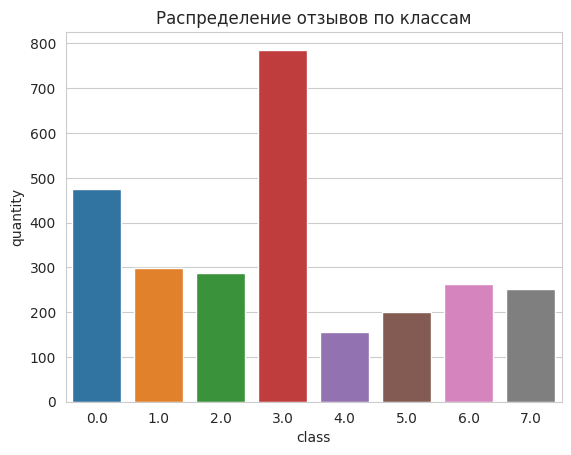

In [ ]:
#Посмотрим на распределение классов:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

grouped_df = df[['class', 'id']].groupby('class').count()
sns.barplot(x=grouped_df.index, y=grouped_df['id'])
plt.title('Распределение отзывов по классам')
plt.ylabel('quantity')
plt.show()

Например, мы видим, что в четвёртом классе объектов столько же, сколько в 5, 6, 7, 8 вместе взятых.

Чтобы избавиться от этой проблемы, сделаем oversampling с помощью класса SMOTE. Для этого просто применим соответсвующую функцию к нашим эмбеддингам:

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_, y_ = smote.fit_resample(X, y)

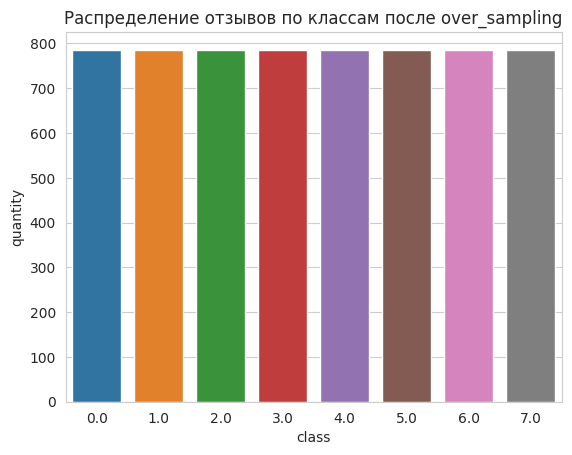

In [ ]:
sns.barplot(x=pd.Series(y_).value_counts().keys(), y=pd.Series(y_).value_counts().values)
plt.xlabel('class')
plt.ylabel('quantity')
plt.title('Распределение отзывов по классам после over_sampling')
plt.show()

## Построение ансамбля

В этой части мы построим ансамбль, состоящий из 4 моделей классификации:

1) линейная модель (какая именно -- будет подобрано с помощью GridSearchCV)

2) RandomForest, т.к. он хорошо себя показывает при классификации с малым набором данных, как у нас

3) Light Gradient Boosting Machine

4) XGBoost, потому что бустинг -- один из самых эффективных ML-алгоритмов для работы с табличными данными

Так как в ансамбль имеет смысл добавлять только уже подтюненные (т.е. с подобранными гиперпараметрами) модели, то сделаем их таковыми с помощью GridSearchCV.

В качестве метрики, под которую будем подстраиваться, выберем f1-меру с макро-усреднением, т.к. при таком варианте предсказания всех классов имеют равный вклад (если бы мы взяли микро-усреднение, то тогда предсказания бы классов более крупных были более значимы для модели).

Также обратим внимание, что я не выделяла отдельно валидационную выборку, потому что в GridSearchCV и так уже используется кросс-валидация, т.е. выборка автоматически разбивается на обучающую и валидационную.

In [ ]:
from sklearn.model_selection import train_test_split

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

def f1_macro(self, X, y):
    return f1_score(y, self.predict(X), average='macro')

#Тюним RandomForest
n_estimators = [80, 160]
max_depth = [25, 40]
min_samples_leaf = [2, 3]
bootstrap = [True, False]

param_grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
    "random_state": [42], #для воспроизводимости результатов
}

rf = RandomForestClassifier()
grid_rf_macro = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring=f1_macro)
grid_rf_macro.fit(X_train_, y_train_.ravel())

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_depth': [25, 40],
                         'min_samples_leaf': [2, 3], 'n_estimators': [80, 160],
                         'random_state': [42]},
             scoring=<function f1_macro at 0x7d04a78655a0>)

In [ ]:
grid_rf_macro.best_params_

{'bootstrap': False,
 'max_depth': 25,
 'min_samples_leaf': 2,
 'n_estimators': 160,
 'random_state': 42}

In [ ]:
rf_macro = RandomForestClassifier(**grid_rf_macro.best_params_)
rf_macro.fit(X_train_, y_train_)
f1_score(y_test_, rf_macro.predict(X_test_), average='macro')

0.84654679793817

In [ ]:
from sklearn.linear_model import SGDClassifier

#Подбираем линейный классификатор, а также его параметры
loss = ['hinge', 'log_loss', 'modified_huber', 'squared_hinge']
shuffle = [True]
max_iter = [100, 500, 1000]
penalty = ['l2', 'elasticnet']
alpha = [0.0001, 0.001]

param_grid = {
    'loss': loss,
    'shuffle': shuffle,
    'max_iter': max_iter,
    'penalty': penalty,
    'alpha': alpha,
    'random_state': [42],
}

sgd = SGDClassifier()
grid_sgd_macro = GridSearchCV(estimator=sgd, param_grid=param_grid, cv=3, scoring=f1_macro)
grid_sgd_macro.fit(X_train_, y_train_.ravel())

GridSearchCV(cv=3, estimator=SGDClassifier(),
             param_grid={'alpha': [0.0001, 0.001], 'class_weight': ['balanced'],
                         'loss': ['hinge', 'log_loss', 'modified_huber',
                                  'squared_hinge'],
                         'max_iter': [1000, 1500, 2000],
                         'penalty': ['l2', 'elasticnet'], 'random_state': [42],
                         'shuffle': [True]},
             scoring=<function f1_macro at 0x7d04a78655a0>)

In [ ]:
grid_sgd_macro.best_params_

{'alpha': 0.0001,
 'class_weight': 'balanced',
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'penalty': 'l2',
 'random_state': 42,
 'shuffle': True}

In [ ]:
sgd_macro = SGDClassifier(**grid_sgd_macro.best_params_)
sgd_macro.fit(X_train_, y_train_)
f1_score(y_test_, sgd_macro.predict(X_test_), average='macro')

0.5436843774017626

In [ ]:
from lightgbm import LGBMClassifier

#Тюним LGBM
param_grid = {
    'num_leaves': [31, 60],
    'learning_rate': [0.1],
    'n_estimators': [200, 300],
    "objective": ["multiclass"],
    "num_classes": [8],
    "random_state": [42],
}
lgb = LGBMClassifier(verbose=-1)
grid_lgb_macro = GridSearchCV(estimator=lgb, param_grid=param_grid, cv=3, scoring=f1_macro)
grid_lgb_macro.fit(X_train_, y_train_.ravel())

GridSearchCV(cv=3, estimator=LGBMClassifier(verbose=-1),
             param_grid={'learning_rate': [0.1], 'n_estimators': [200, 300],
                         'num_classes': [8], 'num_leaves': [31, 60],
                         'objective': ['multiclass'], 'random_state': [42]},
             scoring=<function f1_macro at 0x7d04a78655a0>)

In [ ]:
grid_lgb_macro.best_params_

{'learning_rate': 0.1,
 'n_estimators': 200,
 'num_classes': 8,
 'num_leaves': 31,
 'objective': 'multiclass',
 'random_state': 42}

In [ ]:
lgb_macro = LGBMClassifier(**grid_lgb_macro.best_params_ , verbose=-1)
lgb_macro.fit(X_train_, y_train_)
f1_score(y_test_, lgb_macro.predict(X_test_), average=None)

array([0.66666667, 0.93159609, 0.88401254, 0.6006006 , 0.94769231,
       0.93197279, 0.84385382, 0.93294461])

In [ ]:
f1_score(y_test_, lgb_macro.predict(X_test_), average='macro')

0.8424174276846733

In [ ]:
from xgboost import XGBClassifier

#Тюним XGBoost
param_grid = {
    "max_leaves": [0],
    "objective": ["multiclass"],
    "num_classes": [8],
    "random_state": [42],
    "max_depth": [5, 6],
    "learning_rate": [0.2],
    "n_estimators": [300, 400],
}

xgb = XGBClassifier()
grid_xgb_macro = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring=f1_macro)
grid_xgb_macro.fit(X_train_, y_train_.ravel())

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 6],
                         'max_leaves': [0], 'n_estimators': [300, 400],
                         'num_classes': [8], 'objective': ['multiclass'],
                         'random_state': [42]},
             scoring=<function f1_macro at 0x7d04a78655a0>)

In [ ]:
grid_xgb_macro.best_params_

{'learning_rate': 0.2,
 'max_depth': 6,
 'max_leaves': 0,
 'n_estimators': 400,
 'num_classes': 8,
 'objective': 'multiclass',
 'random_state': 42}

In [ ]:
xgb_macro = XGBClassifier(**grid_xgb_macro.best_params_ , verbose=-1)
xgb_macro.fit(X_train_, y_train_)
f1_score(y_test_, xgb_macro.predict(X_test_), average=None)

array([0.69127517, 0.9201278 , 0.87179487, 0.56393443, 0.93902439,
       0.87581699, 0.83501684, 0.89635854])

In [ ]:
f1_score(y_test_, xgb_macro.predict(X_test_), average='macro')

0.8360469794469084

In [ ]:
weights = [0.3, 0.1, 0.3, 0.3] #подобраны в соответствии с качеством, которое выдавала каждая модель
ensemble = VotingClassifier(estimators=[('rf', rf_macro),
                                        ('sgd', sgd_macro),
                                        ('lgb',lgb_macro),
                                        ('xgb', xgb_macro)],
                            weights=weights, voting='hard')
ensemble.fit(X_train_, y_train_)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=25,
                                                     min_samples_leaf=2,
                                                     n_estimators=160,
                                                     random_state=42)),
                             ('sgd',
                              SGDClassifier(class_weight='balanced',
                                            loss='squared_hinge',
                                            random_state=42)),
                             ('lgb',
                              LGBMClassifier(n_estimators=200, num_classes=8,
                                             objective='multiclass',
                                             random_state=42, verbose=-1)),
                             ('xgb',
                              XGBClassifier...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=0, min_child_weight=None,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=None,
                                            num_classes=8,
                                            num_parallel_tree=None, ...))],
                 weights=[0.3, 0.1, 0.3, 0.3])

In [ ]:
print("f1_score ансамбля на тестовой выборке:", f1_score(y_test_, ensemble.predict(X_test_),
                                                         average='macro'))

f1_score ансамбля на тестовой выборке: 0.8422785308033354


# BERT

В этой части мы файн-тьюним трансформер BERT, предобученный на русских текстах также на задачу классификации

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification

In [ ]:
#Преобразуем названия классов в цифры от 0 до 7
enc_dict = {"Вежливость сотрудников магазина": 0, "Время ожидания у кассы": 1,
           "Доступность персонала в магазине": 2, "Компетентность продавцов/ консультантов": 3,
           "Консультация КЦ": 4, "Обслуживание на кассе": 5,
           "Обслуживание продавцами/ консультантами": 6, "Электронная очередь": 7}

inv_enc_dict = {0: "Вежливость сотрудников магазина", 1: "Время ожидания у кассы",
               2: "Доступность персонала в магазине", 3: "Компетентность продавцов/ консультантов",
               4: "Консультация КЦ", 5: "Обслуживание на кассе",
               6: "Обслуживание продавцами/ консультантами", 7: "Электронная очередь"}

df['class'] = df['class'].map(enc_dict)
df

,id,text,class
0,45,негатив к вам и горячей линии которые нафиг н...,4
1,97,перестаньте впаривать клиентам дополнительные ...,3
2,105,продавец предложил наклеить защитную плёнку з...,3
3,127,продавец режил продать нам товар почему то по ...,3
4,130,навязанные услуги ( без моего согласия) на сум...,3
...,...,...,...
2832,17570,почему отключили электронную очередь через пол...,7
2833,17579,очередь на кассе. продавцы не торопятся с зака...,1
2834,17586,"профессионализма менеджеру бы, да и внимания к...",6
2835,17591,сотрудник на выдаче заказа потребовал документ...,7


Опять решим проблему oversampling'a, только на тот раз, т.к. у нас нет быстрого доступа к скрытому признаковому пространству, как это было в предыдущий раз, используем RandomOverSapmpler, который  генерирует новые данные для меньшего класса путём случайного выбора одного объекта из выборки с возвращением.

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(np.array(df['text']).reshape(-1, 1), np.array(df['class']).reshape(-1, 1))
df_ros = pd.DataFrame(list(zip([x[0] for x in X_ros], y_ros)), columns = ['text', 'class'])
df_ros

,text,class
0,негатив к вам и горячей линии которые нафиг н...,4
1,перестаньте впаривать клиентам дополнительные ...,3
2,продавец предложил наклеить защитную плёнку з...,3
3,продавец режил продать нам товар почему то по ...,3
4,навязанные услуги ( без моего согласия) на сум...,3
...,...,...
6595,долгое обслуживание. какой-то талончик при вхо...,7
6596,"пришёл, взял талон, на выдаче никого и в очере...",7
6597,очень тяжело найти этот магазин. электронный н...,7
6598,"добавьте в смс о готовности товара информацию,...",7


Напишем саму модель:

In [ ]:
class BertDataset(Dataset):
    def __init__(self, df):
        tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny')
        self.tokens = [tokenizer(text, padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df.text]
        self.labels = df['class'].to_numpy()

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        return self.tokens[idx], torch.tensor(self.labels[idx])

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny')
        self.tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny')
        self.n_classes = 8
        self.loss_fn = torch.nn.CrossEntropyLoss().cuda()
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, self.n_classes)
        self.model = self.model.cuda()

    def forward(self, input_id, mask):
        return self.model(input_id, mask)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

def test(model, loader):
    total_acc_val, total_loss_val, total_f1_val, total_pr_val, total_rec_val = 0, 0, 0, 0, 0
    model.eval()
    with torch.no_grad():
        for val_input, val_label in tqdm(loader):
            val_label = val_label.cuda()
            mask = val_input['attention_mask'].cuda()
            input_id = val_input['input_ids'].squeeze(1).cuda()

            output = model(input_id, mask)

            batch_loss = model.loss_fn(output[0], val_label.long())
            total_loss_val += batch_loss.item()

            f1 = f1_score(val_label.cpu(), output[0].argmax(dim=1).cpu(), average='macro')
            total_f1_val += f1

            acc = accuracy_score(val_label.cpu(), output[0].argmax(dim=1).cpu())
            total_acc_val += acc
    acc_val, loss_val, f1_val = total_acc_val / len(loader), total_loss_val / len(loader), total_f1_val / len(loader)
    return acc_val, loss_val, f1_val


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    model.train()
    for epoch_num in range(n_epochs):
        total_acc_train, total_loss_train, total_f1_train, total_pr_train, total_rec_train = 0, 0, 0, 0, 0
        for train_input, train_label in tqdm(train_loader):
            train_label = train_label.cuda()
            mask = train_input['attention_mask'].cuda()
            input_id = train_input['input_ids'].squeeze(1).cuda()
            output = model(input_id, mask)

            batch_loss = model.loss_fn(output[0], train_label.long())
            total_loss_train += batch_loss.item()

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

            f1 = f1_score(train_label.cpu(), output[0].argmax(dim=1).cpu(), average='macro')
            total_f1_train += f1

            acc = accuracy_score(train_label.cpu(), output[0].argmax(dim=1).cpu())
            total_acc_train += acc

        acc_val, loss_val, f1_val = test(model, val_loader)
        if scheduler is not None:
            scheduler.step(loss_val)
        acc_train, loss_train, f1_train = total_acc_train / len(train_loader), total_loss_train / len(train_loader), total_f1_train / len(train_loader)
        print(f"Epochs: {epoch_num + 1} | Train Loss: {loss_train: .3f} | Train Acc: {acc_train: .3f} \
        | Train F1: {f1_train: .3f} | Val Loss: {loss_val: .3f} \
        | Val Acc: {acc_val: .3f} | Val F1: {f1_val: .3f}")

    return acc_train, loss_train, f1_train

В качестве оптимизатора возьмём Adam с weight_decay'ем, а в качестве шедулера -- cosine annealing with warmup, т.к. в документации BERT написано, что лучше для этого трансформера брать именно AdamW и какой-нибудь шедулер с warmup).

In [ ]:
from transformers import AdamW, get_cosine_schedule_with_warmup

df_train, df_test, _, _ = train_test_split(df_ros[['text', 'class']], np.zeros(df_ros.shape[0]), random_state=42)
df_train, df_val, _, _ = train_test_split(df_train, np.zeros(df_train.shape[0]), random_state=42)
train_dataset, val_dataset, test_dataset = BertDataset(df_train), BertDataset(df_val), BertDataset(df_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                            num_training_steps=len(train_loader) * n_epochs)
n_epochs = 15
bert = BertClassifier()
optimizer = AdamW(bert.parameters(), lr=2e-5)

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

NameError: name 'optimizer' is not defined

In [ ]:
train(bert, optimizer, n_epochs, train_loader, val_loader, scheduler)

100%|██████████| 19/19 [00:01<00:00, 11.07it/s]


Epochs: 1 | Train Loss:  2.017 | Train Acc:  0.207         | Train F1:  0.167 | Val Loss:  1.924         | Val Acc:  0.331 | Val F1:  0.279


100%|██████████| 19/19 [00:01<00:00, 11.13it/s]


Epochs: 2 | Train Loss:  1.742 | Train Acc:  0.482         | Train F1:  0.430 | Val Loss:  1.476         | Val Acc:  0.638 | Val F1:  0.605


100%|██████████| 19/19 [00:01<00:00, 11.15it/s]


Epochs: 3 | Train Loss:  1.216 | Train Acc:  0.701         | Train F1:  0.670 | Val Loss:  0.991         | Val Acc:  0.751 | Val F1:  0.739


100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


Epochs: 4 | Train Loss:  0.841 | Train Acc:  0.798         | Train F1:  0.778 | Val Loss:  0.741         | Val Acc:  0.805 | Val F1:  0.794


100%|██████████| 19/19 [00:01<00:00, 11.17it/s]


Epochs: 5 | Train Loss:  0.618 | Train Acc:  0.856         | Train F1:  0.843 | Val Loss:  0.593         | Val Acc:  0.838 | Val F1:  0.829


100%|██████████| 19/19 [00:01<00:00, 11.17it/s]


Epochs: 6 | Train Loss:  0.469 | Train Acc:  0.897         | Train F1:  0.890 | Val Loss:  0.504         | Val Acc:  0.863 | Val F1:  0.854


100%|██████████| 19/19 [00:01<00:00, 11.13it/s]


Epochs: 7 | Train Loss:  0.358 | Train Acc:  0.925         | Train F1:  0.918 | Val Loss:  0.414         | Val Acc:  0.888 | Val F1:  0.880


100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


Epochs: 8 | Train Loss:  0.274 | Train Acc:  0.946         | Train F1:  0.941 | Val Loss:  0.371         | Val Acc:  0.895 | Val F1:  0.887


100%|██████████| 19/19 [00:01<00:00, 11.01it/s]


Epochs: 9 | Train Loss:  0.207 | Train Acc:  0.967         | Train F1:  0.963 | Val Loss:  0.323         | Val Acc:  0.911 | Val F1:  0.905


100%|██████████| 19/19 [00:01<00:00, 11.09it/s]


Epochs: 10 | Train Loss:  0.157 | Train Acc:  0.977         | Train F1:  0.976 | Val Loss:  0.295         | Val Acc:  0.922 | Val F1:  0.918


100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


Epochs: 11 | Train Loss:  0.120 | Train Acc:  0.987         | Train F1:  0.985 | Val Loss:  0.267         | Val Acc:  0.924 | Val F1:  0.922


100%|██████████| 19/19 [00:01<00:00, 11.14it/s]


Epochs: 12 | Train Loss:  0.091 | Train Acc:  0.993         | Train F1:  0.992 | Val Loss:  0.257         | Val Acc:  0.923 | Val F1:  0.920


100%|██████████| 19/19 [00:01<00:00, 11.13it/s]


Epochs: 13 | Train Loss:  0.071 | Train Acc:  0.994         | Train F1:  0.993 | Val Loss:  0.239         | Val Acc:  0.927 | Val F1:  0.926


100%|██████████| 19/19 [00:01<00:00, 11.15it/s]


Epochs: 14 | Train Loss:  0.055 | Train Acc:  0.996         | Train F1:  0.996 | Val Loss:  0.245         | Val Acc:  0.929 | Val F1:  0.927


100%|██████████| 19/19 [00:01<00:00, 11.12it/s]

Epochs: 15 | Train Loss:  0.045 | Train Acc:  0.997         | Train F1:  0.997 | Val Loss:  0.236         | Val Acc:  0.927 | Val F1:  0.924


(0.9974888392857143, 0.044670044644070525, 0.9972955746283727)

In [ ]:
acc, loss, f1 = test(bert, test_loader)
print("f1-score на тестовой выборке:", f1)

100%|██████████| 25/25 [00:02<00:00, 10.89it/s]

f1-score на тестовой выборке: 0.9240130212625702


In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
#Тюним AdamW
n_epochs = 18
lrs = [1e-5, 2e-5, 1e-4, 1e-3]
adam_lr = pd.DataFrame(columns=lrs)
for lr in lrs:
    bert = BertClassifier()
    optimizer = AdamW(bert.parameters(), lr=lr)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                                num_training_steps=len(train_loader) * n_epochs)
    train(bert, optimizer, n_epochs, train_loader, val_loader)
    acc, loss, f1 = test(bert, test_loader)
    results = [loss, acc, f1]
    adam_lr[lr] = results

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 20/20 [00:02<00:00,  6.98it/s]


Epochs: 1 | Train Loss:  2.067 | Train Acc:  0.162         | Train F1:  0.126 | Val Loss:  2.034         | Val Acc:  0.260 | Val F1:  0.206


100%|██████████| 20/20 [00:02<00:00,  6.81it/s]


Epochs: 2 | Train Loss:  1.993 | Train Acc:  0.319         | Train F1:  0.266 | Val Loss:  1.942         | Val Acc:  0.393 | Val F1:  0.343


100%|██████████| 20/20 [00:03<00:00,  6.60it/s]


Epochs: 3 | Train Loss:  1.838 | Train Acc:  0.470         | Train F1:  0.429 | Val Loss:  1.720         | Val Acc:  0.519 | Val F1:  0.468


100%|██████████| 20/20 [00:03<00:00,  6.36it/s]


Epochs: 4 | Train Loss:  1.538 | Train Acc:  0.585         | Train F1:  0.547 | Val Loss:  1.392         | Val Acc:  0.630 | Val F1:  0.601


100%|██████████| 20/20 [00:03<00:00,  6.57it/s]


Epochs: 5 | Train Loss:  1.228 | Train Acc:  0.689         | Train F1:  0.669 | Val Loss:  1.138         | Val Acc:  0.695 | Val F1:  0.673


100%|██████████| 20/20 [00:03<00:00,  6.58it/s]


Epochs: 6 | Train Loss:  0.998 | Train Acc:  0.757         | Train F1:  0.736 | Val Loss:  0.958         | Val Acc:  0.762 | Val F1:  0.737


100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


Epochs: 7 | Train Loss:  0.828 | Train Acc:  0.814         | Train F1:  0.798 | Val Loss:  0.819         | Val Acc:  0.795 | Val F1:  0.772


100%|██████████| 20/20 [00:03<00:00,  6.45it/s]


Epochs: 8 | Train Loss:  0.690 | Train Acc:  0.854         | Train F1:  0.843 | Val Loss:  0.706         | Val Acc:  0.825 | Val F1:  0.800


100%|██████████| 20/20 [00:03<00:00,  6.49it/s]


Epochs: 9 | Train Loss:  0.576 | Train Acc:  0.887         | Train F1:  0.880 | Val Loss:  0.617         | Val Acc:  0.847 | Val F1:  0.828


100%|██████████| 20/20 [00:03<00:00,  6.50it/s]


Epochs: 10 | Train Loss:  0.485 | Train Acc:  0.910         | Train F1:  0.903 | Val Loss:  0.545         | Val Acc:  0.860 | Val F1:  0.842


100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


Epochs: 11 | Train Loss:  0.411 | Train Acc:  0.927         | Train F1:  0.922 | Val Loss:  0.491         | Val Acc:  0.876 | Val F1:  0.858


100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


Epochs: 12 | Train Loss:  0.350 | Train Acc:  0.946         | Train F1:  0.943 | Val Loss:  0.447         | Val Acc:  0.881 | Val F1:  0.863


100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


Epochs: 13 | Train Loss:  0.298 | Train Acc:  0.955         | Train F1:  0.952 | Val Loss:  0.404         | Val Acc:  0.893 | Val F1:  0.877


100%|██████████| 20/20 [00:03<00:00,  6.45it/s]


Epochs: 14 | Train Loss:  0.252 | Train Acc:  0.961         | Train F1:  0.957 | Val Loss:  0.369         | Val Acc:  0.903 | Val F1:  0.886


100%|██████████| 20/20 [00:03<00:00,  6.43it/s]


Epochs: 15 | Train Loss:  0.215 | Train Acc:  0.966         | Train F1:  0.963 | Val Loss:  0.349         | Val Acc:  0.906 | Val F1:  0.895


100%|██████████| 20/20 [00:03<00:00,  6.40it/s]


Epochs: 16 | Train Loss:  0.183 | Train Acc:  0.974         | Train F1:  0.973 | Val Loss:  0.331         | Val Acc:  0.910 | Val F1:  0.900


100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


Epochs: 17 | Train Loss:  0.155 | Train Acc:  0.981         | Train F1:  0.980 | Val Loss:  0.311         | Val Acc:  0.925 | Val F1:  0.916


100%|██████████| 20/20 [00:03<00:00,  6.51it/s]


Epochs: 18 | Train Loss:  0.133 | Train Acc:  0.987         | Train F1:  0.985 | Val Loss:  0.302         | Val Acc:  0.924 | Val F1:  0.914


100%|██████████| 26/26 [00:04<00:00,  6.36it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 20/20 [00:03<00:00,  6.49it/s]


Epochs: 1 | Train Loss:  2.039 | Train Acc:  0.218         | Train F1:  0.170 | Val Loss:  1.963         | Val Acc:  0.368 | Val F1:  0.317


100%|██████████| 20/20 [00:03<00:00,  6.49it/s]


Epochs: 2 | Train Loss:  1.745 | Train Acc:  0.516         | Train F1:  0.484 | Val Loss:  1.474         | Val Acc:  0.594 | Val F1:  0.564


100%|██████████| 20/20 [00:03<00:00,  6.50it/s]


Epochs: 3 | Train Loss:  1.209 | Train Acc:  0.670         | Train F1:  0.649 | Val Loss:  1.042         | Val Acc:  0.689 | Val F1:  0.666


100%|██████████| 20/20 [00:03<00:00,  6.52it/s]


Epochs: 4 | Train Loss:  0.851 | Train Acc:  0.773         | Train F1:  0.756 | Val Loss:  0.785         | Val Acc:  0.755 | Val F1:  0.726


100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


Epochs: 5 | Train Loss:  0.628 | Train Acc:  0.833         | Train F1:  0.820 | Val Loss:  0.637         | Val Acc:  0.798 | Val F1:  0.778


100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


Epochs: 6 | Train Loss:  0.475 | Train Acc:  0.884         | Train F1:  0.878 | Val Loss:  0.518         | Val Acc:  0.848 | Val F1:  0.831


100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


Epochs: 7 | Train Loss:  0.356 | Train Acc:  0.923         | Train F1:  0.921 | Val Loss:  0.441         | Val Acc:  0.870 | Val F1:  0.850


100%|██████████| 20/20 [00:03<00:00,  6.44it/s]


Epochs: 8 | Train Loss:  0.267 | Train Acc:  0.948         | Train F1:  0.944 | Val Loss:  0.376         | Val Acc:  0.896 | Val F1:  0.884


100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


Epochs: 9 | Train Loss:  0.199 | Train Acc:  0.963         | Train F1:  0.960 | Val Loss:  0.339         | Val Acc:  0.902 | Val F1:  0.893


100%|██████████| 20/20 [00:03<00:00,  6.52it/s]


Epochs: 10 | Train Loss:  0.148 | Train Acc:  0.978         | Train F1:  0.975 | Val Loss:  0.304         | Val Acc:  0.910 | Val F1:  0.900


100%|██████████| 20/20 [00:03<00:00,  6.49it/s]


Epochs: 11 | Train Loss:  0.111 | Train Acc:  0.988         | Train F1:  0.987 | Val Loss:  0.293         | Val Acc:  0.917 | Val F1:  0.911


100%|██████████| 20/20 [00:03<00:00,  6.50it/s]


Epochs: 12 | Train Loss:  0.083 | Train Acc:  0.992         | Train F1:  0.991 | Val Loss:  0.266         | Val Acc:  0.924 | Val F1:  0.919


100%|██████████| 20/20 [00:03<00:00,  6.50it/s]


Epochs: 13 | Train Loss:  0.063 | Train Acc:  0.995         | Train F1:  0.994 | Val Loss:  0.277         | Val Acc:  0.920 | Val F1:  0.914


100%|██████████| 20/20 [00:03<00:00,  6.50it/s]


Epochs: 14 | Train Loss:  0.047 | Train Acc:  0.997         | Train F1:  0.997 | Val Loss:  0.260         | Val Acc:  0.921 | Val F1:  0.916


100%|██████████| 20/20 [00:03<00:00,  6.50it/s]


Epochs: 15 | Train Loss:  0.036 | Train Acc:  0.999         | Train F1:  0.999 | Val Loss:  0.268         | Val Acc:  0.921 | Val F1:  0.916


100%|██████████| 20/20 [00:03<00:00,  6.49it/s]


Epochs: 16 | Train Loss:  0.029 | Train Acc:  0.999         | Train F1:  0.999 | Val Loss:  0.258         | Val Acc:  0.926 | Val F1:  0.921


100%|██████████| 20/20 [00:03<00:00,  6.44it/s]


Epochs: 17 | Train Loss:  0.024 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.267         | Val Acc:  0.922 | Val F1:  0.916


100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


Epochs: 18 | Train Loss:  0.020 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.270         | Val Acc:  0.923 | Val F1:  0.918


100%|██████████| 26/26 [00:04<00:00,  6.34it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 20/20 [00:03<00:00,  6.49it/s]


Epochs: 1 | Train Loss:  1.534 | Train Acc:  0.489         | Train F1:  0.452 | Val Loss:  0.864         | Val Acc:  0.728 | Val F1:  0.709


100%|██████████| 20/20 [00:03<00:00,  6.50it/s]


Epochs: 2 | Train Loss:  0.536 | Train Acc:  0.851         | Train F1:  0.843 | Val Loss:  0.421         | Val Acc:  0.866 | Val F1:  0.849


100%|██████████| 20/20 [00:03<00:00,  6.48it/s]


Epochs: 3 | Train Loss:  0.209 | Train Acc:  0.948         | Train F1:  0.944 | Val Loss:  0.270         | Val Acc:  0.923 | Val F1:  0.908


100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


Epochs: 4 | Train Loss:  0.081 | Train Acc:  0.985         | Train F1:  0.983 | Val Loss:  0.301         | Val Acc:  0.909 | Val F1:  0.894


100%|██████████| 20/20 [00:03<00:00,  6.44it/s]


Epochs: 5 | Train Loss:  0.035 | Train Acc:  0.995         | Train F1:  0.996 | Val Loss:  0.237         | Val Acc:  0.934 | Val F1:  0.924


100%|██████████| 20/20 [00:03<00:00,  6.51it/s]


Epochs: 6 | Train Loss:  0.015 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.241         | Val Acc:  0.938 | Val F1:  0.928


100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


Epochs: 7 | Train Loss:  0.008 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.263         | Val Acc:  0.929 | Val F1:  0.918


100%|██████████| 20/20 [00:03<00:00,  6.48it/s]


Epochs: 8 | Train Loss:  0.006 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.264         | Val Acc:  0.928 | Val F1:  0.917


100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


Epochs: 9 | Train Loss:  0.005 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.273         | Val Acc:  0.931 | Val F1:  0.920


100%|██████████| 20/20 [00:03<00:00,  6.48it/s]


Epochs: 10 | Train Loss:  0.004 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.276         | Val Acc:  0.931 | Val F1:  0.921


100%|██████████| 20/20 [00:03<00:00,  6.49it/s]


Epochs: 11 | Train Loss:  0.003 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.284         | Val Acc:  0.931 | Val F1:  0.921


100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


Epochs: 12 | Train Loss:  0.003 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.286         | Val Acc:  0.931 | Val F1:  0.921


100%|██████████| 20/20 [00:03<00:00,  6.49it/s]


Epochs: 13 | Train Loss:  0.002 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.291         | Val Acc:  0.931 | Val F1:  0.921


100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


Epochs: 14 | Train Loss:  0.002 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.298         | Val Acc:  0.931 | Val F1:  0.920


100%|██████████| 20/20 [00:03<00:00,  6.42it/s]


Epochs: 15 | Train Loss:  0.002 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.301         | Val Acc:  0.931 | Val F1:  0.921


100%|██████████| 20/20 [00:03<00:00,  6.45it/s]


Epochs: 16 | Train Loss:  0.002 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.305         | Val Acc:  0.933 | Val F1:  0.923


100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


Epochs: 17 | Train Loss:  0.001 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.307         | Val Acc:  0.933 | Val F1:  0.923


100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


Epochs: 18 | Train Loss:  0.001 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.311         | Val Acc:  0.933 | Val F1:  0.924


100%|██████████| 26/26 [00:04<00:00,  6.34it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


Epochs: 1 | Train Loss:  0.935 | Train Acc:  0.659         | Train F1:  0.634 | Val Loss:  0.435         | Val Acc:  0.856 | Val F1:  0.844


100%|██████████| 20/20 [00:03<00:00,  6.45it/s]


Epochs: 2 | Train Loss:  0.260 | Train Acc:  0.922         | Train F1:  0.916 | Val Loss:  0.399         | Val Acc:  0.887 | Val F1:  0.883


100%|██████████| 20/20 [00:03<00:00,  6.51it/s]


Epochs: 3 | Train Loss:  0.098 | Train Acc:  0.970         | Train F1:  0.967 | Val Loss:  0.377         | Val Acc:  0.907 | Val F1:  0.898


100%|██████████| 20/20 [00:03<00:00,  6.51it/s]


Epochs: 4 | Train Loss:  0.089 | Train Acc:  0.972         | Train F1:  0.970 | Val Loss:  0.454         | Val Acc:  0.893 | Val F1:  0.882


100%|██████████| 20/20 [00:03<00:00,  6.52it/s]


Epochs: 5 | Train Loss:  0.144 | Train Acc:  0.957         | Train F1:  0.952 | Val Loss:  0.524         | Val Acc:  0.881 | Val F1:  0.870


100%|██████████| 20/20 [00:03<00:00,  6.52it/s]


Epochs: 6 | Train Loss:  0.090 | Train Acc:  0.971         | Train F1:  0.969 | Val Loss:  0.382         | Val Acc:  0.904 | Val F1:  0.899


100%|██████████| 20/20 [00:03<00:00,  6.51it/s]


Epochs: 7 | Train Loss:  0.077 | Train Acc:  0.977         | Train F1:  0.976 | Val Loss:  0.446         | Val Acc:  0.902 | Val F1:  0.892


100%|██████████| 20/20 [00:03<00:00,  6.48it/s]


Epochs: 8 | Train Loss:  0.032 | Train Acc:  0.987         | Train F1:  0.986 | Val Loss:  0.516         | Val Acc:  0.893 | Val F1:  0.880


100%|██████████| 20/20 [00:03<00:00,  6.51it/s]


Epochs: 9 | Train Loss:  0.033 | Train Acc:  0.991         | Train F1:  0.991 | Val Loss:  0.442         | Val Acc:  0.899 | Val F1:  0.890


100%|██████████| 20/20 [00:03<00:00,  6.49it/s]


Epochs: 10 | Train Loss:  0.046 | Train Acc:  0.987         | Train F1:  0.985 | Val Loss:  0.435         | Val Acc:  0.914 | Val F1:  0.901


100%|██████████| 20/20 [00:03<00:00,  6.51it/s]


Epochs: 11 | Train Loss:  0.073 | Train Acc:  0.979         | Train F1:  0.978 | Val Loss:  0.677         | Val Acc:  0.836 | Val F1:  0.822


100%|██████████| 20/20 [00:03<00:00,  6.51it/s]


Epochs: 12 | Train Loss:  0.138 | Train Acc:  0.961         | Train F1:  0.958 | Val Loss:  0.493         | Val Acc:  0.885 | Val F1:  0.873


100%|██████████| 20/20 [00:03<00:00,  6.54it/s]


Epochs: 13 | Train Loss:  0.101 | Train Acc:  0.970         | Train F1:  0.968 | Val Loss:  0.524         | Val Acc:  0.876 | Val F1:  0.859


100%|██████████| 20/20 [00:03<00:00,  6.52it/s]


Epochs: 14 | Train Loss:  0.072 | Train Acc:  0.981         | Train F1:  0.980 | Val Loss:  0.389         | Val Acc:  0.912 | Val F1:  0.902


100%|██████████| 20/20 [00:03<00:00,  6.50it/s]


Epochs: 15 | Train Loss:  0.018 | Train Acc:  0.994         | Train F1:  0.994 | Val Loss:  0.453         | Val Acc:  0.911 | Val F1:  0.905


100%|██████████| 20/20 [00:03<00:00,  6.51it/s]


Epochs: 16 | Train Loss:  0.023 | Train Acc:  0.994         | Train F1:  0.993 | Val Loss:  0.558         | Val Acc:  0.899 | Val F1:  0.880


100%|██████████| 20/20 [00:03<00:00,  6.51it/s]


Epochs: 17 | Train Loss:  0.034 | Train Acc:  0.989         | Train F1:  0.989 | Val Loss:  0.581         | Val Acc:  0.897 | Val F1:  0.877


100%|██████████| 20/20 [00:03<00:00,  6.49it/s]


Epochs: 18 | Train Loss:  0.037 | Train Acc:  0.988         | Train F1:  0.986 | Val Loss:  0.501         | Val Acc:  0.904 | Val F1:  0.897


100%|██████████| 26/26 [00:04<00:00,  6.35it/s]


In [ ]:
adam_lr

,0.00001,0.00002,0.00010,0.00100
0,0.295181,0.250852,0.270047,0.598320
1,0.923056,0.933819,0.937917,0.870764
2,0.916888,0.930163,0.934674,0.860779


In [ ]:
#Видно, что наибольший f1-score (3 строка таблицы) достигается при lr=1e-4
best_lr = 1e-4

## Подбираем шедулер

In [ ]:
#Тюним CosineAnnealing with warmup
num_warm_steps = [0, 1, 3, 5]
n_epochs = 10
ca_nws = pd.DataFrame(columns=num_warm_steps)
for num_warm_step in num_warm_steps:
    bert = BertClassifier()
    optimizer = AdamW(bert.parameters(), lr=best_lr)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warm_step, num_training_steps=len(train_loader) * n_epochs)
    train(bert, optimizer, n_epochs, train_loader, val_loader, scheduler)
    acc, loss, f1 = test(bert, test_loader)
    results = [loss, acc, f1]
    ca_nws[num_warm_step] = results

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 19/19 [00:01<00:00, 11.13it/s]


Epochs: 1 | Train Loss:  1.613 | Train Acc:  0.450         | Train F1:  0.396 | Val Loss:  0.914         | Val Acc:  0.704 | Val F1:  0.687


100%|██████████| 19/19 [00:01<00:00, 11.17it/s]


Epochs: 2 | Train Loss:  0.564 | Train Acc:  0.838         | Train F1:  0.822 | Val Loss:  0.413         | Val Acc:  0.881 | Val F1:  0.872


100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


Epochs: 3 | Train Loss:  0.237 | Train Acc:  0.935         | Train F1:  0.928 | Val Loss:  0.279         | Val Acc:  0.923 | Val F1:  0.916


100%|██████████| 19/19 [00:01<00:00, 11.19it/s]


Epochs: 4 | Train Loss:  0.098 | Train Acc:  0.981         | Train F1:  0.980 | Val Loss:  0.244         | Val Acc:  0.934 | Val F1:  0.929


100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


Epochs: 5 | Train Loss:  0.038 | Train Acc:  0.996         | Train F1:  0.995 | Val Loss:  0.236         | Val Acc:  0.933 | Val F1:  0.929


100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


Epochs: 6 | Train Loss:  0.015 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.228         | Val Acc:  0.939 | Val F1:  0.934


100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


Epochs: 7 | Train Loss:  0.009 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.249         | Val Acc:  0.936 | Val F1:  0.931


100%|██████████| 19/19 [00:01<00:00, 11.18it/s]


Epochs: 8 | Train Loss:  0.007 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.249         | Val Acc:  0.937 | Val F1:  0.933


100%|██████████| 19/19 [00:01<00:00, 11.17it/s]


Epochs: 9 | Train Loss:  0.005 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.251         | Val Acc:  0.937 | Val F1:  0.933


100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


Epochs: 10 | Train Loss:  0.004 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.256         | Val Acc:  0.937 | Val F1:  0.932


100%|██████████| 25/25 [00:02<00:00, 11.00it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 19/19 [00:01<00:00, 11.19it/s]


Epochs: 1 | Train Loss:  2.082 | Train Acc:  0.119         | Train F1:  0.070 | Val Loss:  2.083         | Val Acc:  0.103 | Val F1:  0.065


100%|██████████| 19/19 [00:01<00:00, 11.17it/s]


Epochs: 2 | Train Loss:  1.485 | Train Acc:  0.520         | Train F1:  0.477 | Val Loss:  0.720         | Val Acc:  0.781 | Val F1:  0.759


100%|██████████| 19/19 [00:01<00:00, 11.18it/s]


Epochs: 3 | Train Loss:  0.462 | Train Acc:  0.870         | Train F1:  0.856 | Val Loss:  0.403         | Val Acc:  0.888 | Val F1:  0.880


100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


Epochs: 4 | Train Loss:  0.220 | Train Acc:  0.946         | Train F1:  0.943 | Val Loss:  0.314         | Val Acc:  0.907 | Val F1:  0.903


100%|██████████| 19/19 [00:01<00:00, 11.13it/s]


Epochs: 5 | Train Loss:  0.134 | Train Acc:  0.973         | Train F1:  0.969 | Val Loss:  0.275         | Val Acc:  0.928 | Val F1:  0.924


100%|██████████| 19/19 [00:01<00:00, 10.90it/s]


Epochs: 6 | Train Loss:  0.088 | Train Acc:  0.988         | Train F1:  0.987 | Val Loss:  0.257         | Val Acc:  0.933 | Val F1:  0.929


100%|██████████| 19/19 [00:01<00:00, 11.07it/s]


Epochs: 7 | Train Loss:  0.061 | Train Acc:  0.993         | Train F1:  0.993 | Val Loss:  0.249         | Val Acc:  0.931 | Val F1:  0.927


100%|██████████| 19/19 [00:01<00:00, 11.03it/s]


Epochs: 8 | Train Loss:  0.044 | Train Acc:  0.996         | Train F1:  0.995 | Val Loss:  0.238         | Val Acc:  0.936 | Val F1:  0.932


100%|██████████| 19/19 [00:01<00:00, 11.10it/s]


Epochs: 9 | Train Loss:  0.033 | Train Acc:  0.999         | Train F1:  0.999 | Val Loss:  0.241         | Val Acc:  0.936 | Val F1:  0.932


100%|██████████| 19/19 [00:01<00:00, 11.09it/s]


Epochs: 10 | Train Loss:  0.026 | Train Acc:  0.999         | Train F1:  0.999 | Val Loss:  0.242         | Val Acc:  0.934 | Val F1:  0.929


100%|██████████| 25/25 [00:02<00:00, 10.92it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 19/19 [00:01<00:00, 11.02it/s]


Epochs: 1 | Train Loss:  2.084 | Train Acc:  0.115         | Train F1:  0.103 | Val Loss:  2.077         | Val Acc:  0.100 | Val F1:  0.083


100%|██████████| 19/19 [00:01<00:00, 11.00it/s]


Epochs: 2 | Train Loss:  1.636 | Train Acc:  0.453         | Train F1:  0.380 | Val Loss:  1.013         | Val Acc:  0.683 | Val F1:  0.657


100%|██████████| 19/19 [00:01<00:00, 11.12it/s]


Epochs: 3 | Train Loss:  0.789 | Train Acc:  0.787         | Train F1:  0.769 | Val Loss:  0.677         | Val Acc:  0.797 | Val F1:  0.783


100%|██████████| 19/19 [00:01<00:00, 11.14it/s]


Epochs: 4 | Train Loss:  0.521 | Train Acc:  0.869         | Train F1:  0.855 | Val Loss:  0.537         | Val Acc:  0.847 | Val F1:  0.838


100%|██████████| 19/19 [00:01<00:00, 11.12it/s]


Epochs: 5 | Train Loss:  0.389 | Train Acc:  0.909         | Train F1:  0.898 | Val Loss:  0.465         | Val Acc:  0.863 | Val F1:  0.852


100%|██████████| 19/19 [00:01<00:00, 11.17it/s]


Epochs: 6 | Train Loss:  0.309 | Train Acc:  0.932         | Train F1:  0.924 | Val Loss:  0.402         | Val Acc:  0.885 | Val F1:  0.877


100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


Epochs: 7 | Train Loss:  0.244 | Train Acc:  0.949         | Train F1:  0.942 | Val Loss:  0.366         | Val Acc:  0.898 | Val F1:  0.890


100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


Epochs: 8 | Train Loss:  0.200 | Train Acc:  0.963         | Train F1:  0.960 | Val Loss:  0.338         | Val Acc:  0.905 | Val F1:  0.896


100%|██████████| 19/19 [00:01<00:00, 11.12it/s]


Epochs: 9 | Train Loss:  0.166 | Train Acc:  0.971         | Train F1:  0.969 | Val Loss:  0.319         | Val Acc:  0.908 | Val F1:  0.900


100%|██████████| 19/19 [00:01<00:00, 11.12it/s]


Epochs: 10 | Train Loss:  0.139 | Train Acc:  0.980         | Train F1:  0.979 | Val Loss:  0.294         | Val Acc:  0.915 | Val F1:  0.909


100%|██████████| 25/25 [00:02<00:00, 10.99it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 19/19 [00:01<00:00, 11.15it/s]


Epochs: 1 | Train Loss:  2.087 | Train Acc:  0.112         | Train F1:  0.091 | Val Loss:  2.080         | Val Acc:  0.131 | Val F1:  0.097


100%|██████████| 19/19 [00:01<00:00, 11.19it/s]


Epochs: 2 | Train Loss:  1.907 | Train Acc:  0.302         | Train F1:  0.257 | Val Loss:  1.560         | Val Acc:  0.560 | Val F1:  0.510


100%|██████████| 19/19 [00:01<00:00, 11.15it/s]


Epochs: 3 | Train Loss:  1.189 | Train Acc:  0.682         | Train F1:  0.642 | Val Loss:  0.865         | Val Acc:  0.780 | Val F1:  0.771


100%|██████████| 19/19 [00:01<00:00, 11.13it/s]


Epochs: 4 | Train Loss:  0.729 | Train Acc:  0.824         | Train F1:  0.809 | Val Loss:  0.661         | Val Acc:  0.821 | Val F1:  0.815


100%|██████████| 19/19 [00:01<00:00, 11.13it/s]


Epochs: 5 | Train Loss:  0.556 | Train Acc:  0.876         | Train F1:  0.862 | Val Loss:  0.561         | Val Acc:  0.846 | Val F1:  0.840


100%|██████████| 19/19 [00:01<00:00, 11.14it/s]


Epochs: 6 | Train Loss:  0.456 | Train Acc:  0.899         | Train F1:  0.891 | Val Loss:  0.502         | Val Acc:  0.862 | Val F1:  0.856


100%|██████████| 19/19 [00:01<00:00, 11.14it/s]


Epochs: 7 | Train Loss:  0.387 | Train Acc:  0.922         | Train F1:  0.913 | Val Loss:  0.453         | Val Acc:  0.875 | Val F1:  0.870


100%|██████████| 19/19 [00:01<00:00, 11.14it/s]


Epochs: 8 | Train Loss:  0.334 | Train Acc:  0.937         | Train F1:  0.930 | Val Loss:  0.421         | Val Acc:  0.879 | Val F1:  0.873


100%|██████████| 19/19 [00:01<00:00, 11.09it/s]


Epochs: 9 | Train Loss:  0.294 | Train Acc:  0.950         | Train F1:  0.948 | Val Loss:  0.393         | Val Acc:  0.886 | Val F1:  0.880


100%|██████████| 19/19 [00:01<00:00, 11.10it/s]


Epochs: 10 | Train Loss:  0.259 | Train Acc:  0.956         | Train F1:  0.953 | Val Loss:  0.372         | Val Acc:  0.890 | Val F1:  0.884


100%|██████████| 25/25 [00:02<00:00, 10.94it/s]


In [ ]:
ca_nws

,0,1,3,5
0,0.260145,0.240865,0.281717,0.376350
1,0.934931,0.931806,0.926319,0.907708
2,0.930654,0.927792,0.920299,0.902115


In [ ]:
from transformers import get_linear_schedule_with_warmup

#Пробуем линейный шедулер с warmup
n_epochs = 10
num_warm_steps = [0, 1, 3, 5]
l_nws = pd.DataFrame(columns=num_warm_steps)
for num_warm_step in num_warm_steps:
    bert = BertClassifier()
    optimizer = AdamW(bert.parameters(), lr=best_lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warm_step,
                                                num_training_steps=len(train_loader) * n_epochs)
    train(bert, optimizer, n_epochs, train_loader, val_loader, scheduler)
    acc, loss, f1 = test(bert, test_loader)
    results = [loss, acc, f1]
    l_nws[num_warm_step] = results

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 1 | Train Loss:  1.606 | Train Acc:  0.450         | Train F1:  0.409 | Val Loss:  0.914         | Val Acc:  0.701 | Val F1:  0.659


100%|██████████| 20/20 [00:01<00:00, 11.13it/s]


Epochs: 2 | Train Loss:  0.550 | Train Acc:  0.837         | Train F1:  0.827 | Val Loss:  0.397         | Val Acc:  0.884 | Val F1:  0.868


100%|██████████| 20/20 [00:01<00:00, 11.08it/s]


Epochs: 3 | Train Loss:  0.209 | Train Acc:  0.946         | Train F1:  0.942 | Val Loss:  0.322         | Val Acc:  0.906 | Val F1:  0.894


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 4 | Train Loss:  0.083 | Train Acc:  0.984         | Train F1:  0.983 | Val Loss:  0.244         | Val Acc:  0.924 | Val F1:  0.915


100%|██████████| 20/20 [00:01<00:00, 11.10it/s]


Epochs: 5 | Train Loss:  0.032 | Train Acc:  0.997         | Train F1:  0.997 | Val Loss:  0.258         | Val Acc:  0.924 | Val F1:  0.913


100%|██████████| 20/20 [00:01<00:00, 11.10it/s]


Epochs: 6 | Train Loss:  0.014 | Train Acc:  0.999         | Train F1:  0.999 | Val Loss:  0.274         | Val Acc:  0.925 | Val F1:  0.915


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 7 | Train Loss:  0.008 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.273         | Val Acc:  0.930 | Val F1:  0.920


100%|██████████| 20/20 [00:01<00:00, 11.13it/s]


Epochs: 8 | Train Loss:  0.006 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.275         | Val Acc:  0.929 | Val F1:  0.920


100%|██████████| 20/20 [00:01<00:00, 11.14it/s]


Epochs: 9 | Train Loss:  0.005 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.290         | Val Acc:  0.928 | Val F1:  0.918


100%|██████████| 20/20 [00:01<00:00, 11.10it/s]


Epochs: 10 | Train Loss:  0.004 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.298         | Val Acc:  0.927 | Val F1:  0.917


100%|██████████| 26/26 [00:02<00:00, 10.88it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 20/20 [00:01<00:00, 11.12it/s]


Epochs: 1 | Train Loss:  2.077 | Train Acc:  0.142         | Train F1:  0.110 | Val Loss:  2.069         | Val Acc:  0.153 | Val F1:  0.112


100%|██████████| 20/20 [00:01<00:00, 11.09it/s]


Epochs: 2 | Train Loss:  1.452 | Train Acc:  0.513         | Train F1:  0.472 | Val Loss:  0.715         | Val Acc:  0.785 | Val F1:  0.765


100%|██████████| 20/20 [00:01<00:00, 11.12it/s]


Epochs: 3 | Train Loss:  0.456 | Train Acc:  0.880         | Train F1:  0.867 | Val Loss:  0.399         | Val Acc:  0.875 | Val F1:  0.862


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 4 | Train Loss:  0.203 | Train Acc:  0.955         | Train F1:  0.953 | Val Loss:  0.308         | Val Acc:  0.906 | Val F1:  0.893


100%|██████████| 20/20 [00:01<00:00, 11.12it/s]


Epochs: 5 | Train Loss:  0.124 | Train Acc:  0.979         | Train F1:  0.976 | Val Loss:  0.272         | Val Acc:  0.922 | Val F1:  0.911


100%|██████████| 20/20 [00:01<00:00, 11.13it/s]


Epochs: 6 | Train Loss:  0.083 | Train Acc:  0.989         | Train F1:  0.989 | Val Loss:  0.264         | Val Acc:  0.920 | Val F1:  0.907


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 7 | Train Loss:  0.057 | Train Acc:  0.994         | Train F1:  0.993 | Val Loss:  0.256         | Val Acc:  0.928 | Val F1:  0.916


100%|██████████| 20/20 [00:01<00:00, 11.14it/s]


Epochs: 8 | Train Loss:  0.041 | Train Acc:  0.998         | Train F1:  0.998 | Val Loss:  0.258         | Val Acc:  0.926 | Val F1:  0.915


100%|██████████| 20/20 [00:01<00:00, 11.17it/s]


Epochs: 9 | Train Loss:  0.030 | Train Acc:  0.999         | Train F1:  0.999 | Val Loss:  0.251         | Val Acc:  0.929 | Val F1:  0.919


100%|██████████| 20/20 [00:01<00:00, 11.13it/s]


Epochs: 10 | Train Loss:  0.023 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.254         | Val Acc:  0.929 | Val F1:  0.919


100%|██████████| 26/26 [00:02<00:00, 10.89it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 1 | Train Loss:  2.086 | Train Acc:  0.121         | Train F1:  0.096 | Val Loss:  2.086         | Val Acc:  0.123 | Val F1:  0.098


100%|██████████| 20/20 [00:01<00:00, 11.03it/s]


Epochs: 2 | Train Loss:  1.661 | Train Acc:  0.457         | Train F1:  0.414 | Val Loss:  0.929         | Val Acc:  0.737 | Val F1:  0.714


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 3 | Train Loss:  0.701 | Train Acc:  0.819         | Train F1:  0.805 | Val Loss:  0.614         | Val Acc:  0.819 | Val F1:  0.797


100%|██████████| 20/20 [00:01<00:00, 11.10it/s]


Epochs: 4 | Train Loss:  0.464 | Train Acc:  0.882         | Train F1:  0.871 | Val Loss:  0.497         | Val Acc:  0.860 | Val F1:  0.833


100%|██████████| 20/20 [00:01<00:00, 11.09it/s]


Epochs: 5 | Train Loss:  0.358 | Train Acc:  0.915         | Train F1:  0.907 | Val Loss:  0.440         | Val Acc:  0.881 | Val F1:  0.861


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


Epochs: 6 | Train Loss:  0.287 | Train Acc:  0.937         | Train F1:  0.930 | Val Loss:  0.388         | Val Acc:  0.889 | Val F1:  0.872


100%|██████████| 20/20 [00:01<00:00, 11.10it/s]


Epochs: 7 | Train Loss:  0.236 | Train Acc:  0.953         | Train F1:  0.951 | Val Loss:  0.354         | Val Acc:  0.896 | Val F1:  0.879


100%|██████████| 20/20 [00:01<00:00, 11.10it/s]


Epochs: 8 | Train Loss:  0.196 | Train Acc:  0.960         | Train F1:  0.956 | Val Loss:  0.335         | Val Acc:  0.901 | Val F1:  0.889


100%|██████████| 20/20 [00:01<00:00, 11.10it/s]


Epochs: 9 | Train Loss:  0.167 | Train Acc:  0.970         | Train F1:  0.968 | Val Loss:  0.314         | Val Acc:  0.913 | Val F1:  0.902


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 10 | Train Loss:  0.142 | Train Acc:  0.978         | Train F1:  0.976 | Val Loss:  0.300         | Val Acc:  0.917 | Val F1:  0.905


100%|██████████| 26/26 [00:02<00:00, 10.80it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 20/20 [00:01<00:00, 11.10it/s]


Epochs: 1 | Train Loss:  2.092 | Train Acc:  0.125         | Train F1:  0.084 | Val Loss:  2.087         | Val Acc:  0.137 | Val F1:  0.086


100%|██████████| 20/20 [00:01<00:00, 11.06it/s]


Epochs: 2 | Train Loss:  1.904 | Train Acc:  0.365         | Train F1:  0.330 | Val Loss:  1.486         | Val Acc:  0.625 | Val F1:  0.583


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 3 | Train Loss:  1.076 | Train Acc:  0.743         | Train F1:  0.720 | Val Loss:  0.816         | Val Acc:  0.773 | Val F1:  0.749


100%|██████████| 20/20 [00:01<00:00, 11.12it/s]


Epochs: 4 | Train Loss:  0.655 | Train Acc:  0.846         | Train F1:  0.830 | Val Loss:  0.646         | Val Acc:  0.822 | Val F1:  0.800


100%|██████████| 20/20 [00:01<00:00, 11.09it/s]


Epochs: 5 | Train Loss:  0.504 | Train Acc:  0.883         | Train F1:  0.874 | Val Loss:  0.559         | Val Acc:  0.846 | Val F1:  0.827


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


Epochs: 6 | Train Loss:  0.412 | Train Acc:  0.915         | Train F1:  0.909 | Val Loss:  0.499         | Val Acc:  0.860 | Val F1:  0.838


100%|██████████| 20/20 [00:01<00:00, 11.09it/s]


Epochs: 7 | Train Loss:  0.349 | Train Acc:  0.930         | Train F1:  0.923 | Val Loss:  0.456         | Val Acc:  0.875 | Val F1:  0.852


100%|██████████| 20/20 [00:01<00:00, 11.14it/s]


Epochs: 8 | Train Loss:  0.300 | Train Acc:  0.942         | Train F1:  0.938 | Val Loss:  0.425         | Val Acc:  0.882 | Val F1:  0.861


100%|██████████| 20/20 [00:01<00:00, 11.09it/s]


Epochs: 9 | Train Loss:  0.260 | Train Acc:  0.953         | Train F1:  0.950 | Val Loss:  0.397         | Val Acc:  0.890 | Val F1:  0.869


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 10 | Train Loss:  0.228 | Train Acc:  0.963         | Train F1:  0.959 | Val Loss:  0.374         | Val Acc:  0.893 | Val F1:  0.874


100%|██████████| 26/26 [00:02<00:00, 10.84it/s]


In [ ]:
l_nws

,0,1,3,5
0,0.253628,0.233562,0.271253,0.337091
1,0.935625,0.936226,0.924135,0.913486
2,0.929661,0.933302,0.919416,0.906900


Видим, что в целом он дал результаты не лучше, чем cosine шедулер (различие в тысячных долях можно считать несущественными, т.к. процесс обучения нейронной сети не детерминирован), а значит, не будем рассматривать его в качестве альтернативы

In [ ]:
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

#Пробуем cosine шедулер с hard restarts (и warmup)
n_epochs = 8
num_warm_steps = [0, 1, 3, 5]
hr_nws = pd.DataFrame(columns=num_warm_steps)
for num_warm_step in num_warm_steps:
    bert = BertClassifier()
    optimizer = AdamW(bert.parameters(), lr=best_lr)
    scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer,
                                                                   num_warmup_steps=num_warm_step,
                                                                   num_training_steps=len(train_loader) * n_epochs)
    train(bert, optimizer, n_epochs, train_loader, val_loader, scheduler)
    acc, loss, f1 = test(bert, test_loader)
    results = [loss, acc, f1]
    hr_nws[num_warm_step] = results

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 1 | Train Loss:  1.675 | Train Acc:  0.423         | Train F1:  0.396 | Val Loss:  1.026         | Val Acc:  0.675 | Val F1:  0.635


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 2 | Train Loss:  0.601 | Train Acc:  0.821         | Train F1:  0.807 | Val Loss:  0.446         | Val Acc:  0.877 | Val F1:  0.860


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 3 | Train Loss:  0.229 | Train Acc:  0.942         | Train F1:  0.938 | Val Loss:  0.274         | Val Acc:  0.918 | Val F1:  0.913


100%|██████████| 20/20 [00:01<00:00, 11.12it/s]


Epochs: 4 | Train Loss:  0.087 | Train Acc:  0.982         | Train F1:  0.980 | Val Loss:  0.256         | Val Acc:  0.924 | Val F1:  0.915


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


Epochs: 5 | Train Loss:  0.034 | Train Acc:  0.997         | Train F1:  0.996 | Val Loss:  0.235         | Val Acc:  0.933 | Val F1:  0.923


100%|██████████| 20/20 [00:01<00:00, 11.07it/s]


Epochs: 6 | Train Loss:  0.014 | Train Acc:  0.999         | Train F1:  0.999 | Val Loss:  0.239         | Val Acc:  0.936 | Val F1:  0.925


100%|██████████| 20/20 [00:01<00:00, 11.10it/s]


Epochs: 7 | Train Loss:  0.008 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.250         | Val Acc:  0.933 | Val F1:  0.921


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 8 | Train Loss:  0.006 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.253         | Val Acc:  0.934 | Val F1:  0.922


100%|██████████| 26/26 [00:02<00:00, 10.85it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 20/20 [00:01<00:00, 11.12it/s]


Epochs: 1 | Train Loss:  2.087 | Train Acc:  0.136         | Train F1:  0.099 | Val Loss:  2.089         | Val Acc:  0.123 | Val F1:  0.080


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


Epochs: 2 | Train Loss:  1.475 | Train Acc:  0.514         | Train F1:  0.469 | Val Loss:  0.719         | Val Acc:  0.791 | Val F1:  0.770


100%|██████████| 20/20 [00:01<00:00, 11.10it/s]


Epochs: 3 | Train Loss:  0.424 | Train Acc:  0.886         | Train F1:  0.877 | Val Loss:  0.375         | Val Acc:  0.897 | Val F1:  0.893


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


Epochs: 4 | Train Loss:  0.187 | Train Acc:  0.960         | Train F1:  0.958 | Val Loss:  0.286         | Val Acc:  0.923 | Val F1:  0.920


100%|██████████| 20/20 [00:01<00:00, 11.08it/s]


Epochs: 5 | Train Loss:  0.113 | Train Acc:  0.981         | Train F1:  0.979 | Val Loss:  0.262         | Val Acc:  0.928 | Val F1:  0.925


100%|██████████| 20/20 [00:01<00:00, 11.09it/s]


Epochs: 6 | Train Loss:  0.076 | Train Acc:  0.991         | Train F1:  0.990 | Val Loss:  0.259         | Val Acc:  0.925 | Val F1:  0.921


100%|██████████| 20/20 [00:01<00:00, 11.12it/s]


Epochs: 7 | Train Loss:  0.053 | Train Acc:  0.997         | Train F1:  0.996 | Val Loss:  0.248         | Val Acc:  0.931 | Val F1:  0.928


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


Epochs: 8 | Train Loss:  0.039 | Train Acc:  0.998         | Train F1:  0.998 | Val Loss:  0.257         | Val Acc:  0.926 | Val F1:  0.922


100%|██████████| 26/26 [00:02<00:00, 10.85it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 20/20 [00:01<00:00, 11.09it/s]


Epochs: 1 | Train Loss:  2.079 | Train Acc:  0.135         | Train F1:  0.108 | Val Loss:  2.077         | Val Acc:  0.138 | Val F1:  0.107


100%|██████████| 20/20 [00:01<00:00, 11.12it/s]


Epochs: 2 | Train Loss:  1.649 | Train Acc:  0.457         | Train F1:  0.415 | Val Loss:  0.954         | Val Acc:  0.743 | Val F1:  0.712


100%|██████████| 20/20 [00:01<00:00, 11.09it/s]


Epochs: 3 | Train Loss:  0.685 | Train Acc:  0.819         | Train F1:  0.801 | Val Loss:  0.595         | Val Acc:  0.831 | Val F1:  0.806


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 4 | Train Loss:  0.434 | Train Acc:  0.894         | Train F1:  0.887 | Val Loss:  0.475         | Val Acc:  0.862 | Val F1:  0.841


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 5 | Train Loss:  0.332 | Train Acc:  0.926         | Train F1:  0.918 | Val Loss:  0.427         | Val Acc:  0.884 | Val F1:  0.867


100%|██████████| 20/20 [00:01<00:00, 11.12it/s]


Epochs: 6 | Train Loss:  0.267 | Train Acc:  0.943         | Train F1:  0.937 | Val Loss:  0.376         | Val Acc:  0.901 | Val F1:  0.887


100%|██████████| 20/20 [00:01<00:00, 11.16it/s]


Epochs: 7 | Train Loss:  0.219 | Train Acc:  0.956         | Train F1:  0.952 | Val Loss:  0.347         | Val Acc:  0.909 | Val F1:  0.897


100%|██████████| 20/20 [00:01<00:00, 11.09it/s]


Epochs: 8 | Train Loss:  0.183 | Train Acc:  0.967         | Train F1:  0.965 | Val Loss:  0.331         | Val Acc:  0.913 | Val F1:  0.900


100%|██████████| 26/26 [00:02<00:00, 10.85it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 20/20 [00:01<00:00, 11.09it/s]


Epochs: 1 | Train Loss:  2.083 | Train Acc:  0.113         | Train F1:  0.101 | Val Loss:  2.082         | Val Acc:  0.103 | Val F1:  0.087


100%|██████████| 20/20 [00:01<00:00, 11.12it/s]


Epochs: 2 | Train Loss:  1.872 | Train Acc:  0.396         | Train F1:  0.366 | Val Loss:  1.441         | Val Acc:  0.612 | Val F1:  0.553


100%|██████████| 20/20 [00:01<00:00, 11.14it/s]


Epochs: 3 | Train Loss:  1.045 | Train Acc:  0.736         | Train F1:  0.708 | Val Loss:  0.824         | Val Acc:  0.772 | Val F1:  0.747


100%|██████████| 20/20 [00:01<00:00, 11.10it/s]


Epochs: 4 | Train Loss:  0.668 | Train Acc:  0.834         | Train F1:  0.817 | Val Loss:  0.654         | Val Acc:  0.815 | Val F1:  0.791


100%|██████████| 20/20 [00:01<00:00, 11.12it/s]


Epochs: 5 | Train Loss:  0.526 | Train Acc:  0.876         | Train F1:  0.865 | Val Loss:  0.564         | Val Acc:  0.844 | Val F1:  0.826


100%|██████████| 20/20 [00:01<00:00, 11.09it/s]


Epochs: 6 | Train Loss:  0.435 | Train Acc:  0.904         | Train F1:  0.899 | Val Loss:  0.505         | Val Acc:  0.864 | Val F1:  0.846


100%|██████████| 20/20 [00:01<00:00, 11.14it/s]


Epochs: 7 | Train Loss:  0.365 | Train Acc:  0.924         | Train F1:  0.917 | Val Loss:  0.463         | Val Acc:  0.875 | Val F1:  0.858


100%|██████████| 20/20 [00:01<00:00, 11.12it/s]


Epochs: 8 | Train Loss:  0.311 | Train Acc:  0.941         | Train F1:  0.935 | Val Loss:  0.415         | Val Acc:  0.891 | Val F1:  0.876


100%|██████████| 26/26 [00:02<00:00, 10.87it/s]


In [ ]:
hr_nws

,0,1,3,5
0,0.221582,0.217770,0.295721,0.399456
1,0.938798,0.940000,0.914183,0.898654
2,0.935784,0.934338,0.908224,0.890939


Опять результаты не превосходят cosine шедулера без hard_restarts, так что этот шедулер тоже не рассматривается в качестве альтернативы.

Таким образом, лучшим оказался cosine scheduler with warmup.

## Сохранение лучшей модели

In [ ]:
n_epochs = 9
bert = BertClassifier()
optimizer = AdamW(bert.parameters(), lr=best_lr)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                            num_training_steps=len(train_loader) * n_epochs)
train(bert, optimizer, n_epochs, train_loader, val_loader, scheduler)
acc, loss, f1 = test(bert, test_loader)
results = [loss, acc, f1]
print(results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 20/20 [00:01<00:00, 11.16it/s]


Epochs: 1 | Train Loss:  1.573 | Train Acc:  0.479         | Train F1:  0.435 | Val Loss:  0.918         | Val Acc:  0.684 | Val F1:  0.643


100%|██████████| 20/20 [00:01<00:00, 11.17it/s]


Epochs: 2 | Train Loss:  0.548 | Train Acc:  0.837         | Train F1:  0.822 | Val Loss:  0.415         | Val Acc:  0.868 | Val F1:  0.850


100%|██████████| 20/20 [00:01<00:00, 11.17it/s]


Epochs: 3 | Train Loss:  0.226 | Train Acc:  0.942         | Train F1:  0.936 | Val Loss:  0.304         | Val Acc:  0.903 | Val F1:  0.886


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epochs: 4 | Train Loss:  0.088 | Train Acc:  0.984         | Train F1:  0.982 | Val Loss:  0.268         | Val Acc:  0.912 | Val F1:  0.896


100%|██████████| 20/20 [00:01<00:00, 11.17it/s]


Epochs: 5 | Train Loss:  0.033 | Train Acc:  0.996         | Train F1:  0.996 | Val Loss:  0.247         | Val Acc:  0.931 | Val F1:  0.921


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


Epochs: 6 | Train Loss:  0.017 | Train Acc:  0.999         | Train F1:  0.999 | Val Loss:  0.275         | Val Acc:  0.924 | Val F1:  0.912


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


Epochs: 7 | Train Loss:  0.009 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.279         | Val Acc:  0.924 | Val F1:  0.912


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


Epochs: 8 | Train Loss:  0.006 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.289         | Val Acc:  0.923 | Val F1:  0.911


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


Epochs: 9 | Train Loss:  0.005 | Train Acc:  1.000         | Train F1:  1.000 | Val Loss:  0.292         | Val Acc:  0.923 | Val F1:  0.911


100%|██████████| 26/26 [00:02<00:00, 10.89it/s]

[0.23412457910867837, 0.9302163461538462, 0.9262305993356326]


In [ ]:
torch.save(bert.state_dict(), "bert.pth")

# Выводы

В ходе работы были предложены два принципиально разных подхода к решению кейса.

1) С помощью классического ML. В этой части была проведена токенизация, полученные токены были лемматизированы и преобразованы в
векторы с помощью обученной модели Word2Vec. Далее была решена проблема несбалансированности классов с помощью SMOTE, который
создаёт новые объекты данных в непосредственной близости от уже существующих в наименьшем классе. После этого был построен ансамбль,
состоящий из алгоритма RandomForest, линейного классификатора и двух алгоритмов бустинга: lightGBM и XGB. Для каждой модели были
подобраны гиперпараметры с помощью GridSearchCV. f1-мера на тестовой выборке составила 0.8423.

2) С помощью DL. Был произведён fine-tuning предобученного на текстах на русском языке также на задачу классификации трансформера BERT.
В рамках этой части были написаны кастомные датасет, класс для классификации BertClassifier, функции обучения и тестирования нейронной
сети. Был подобран learning_rate для используемого оптимизатора AdamW и также был выбран шедулер.
f1-мера на тестовой выборке составила 0.93. Лучшая модель была сохранена с помощью torch.save.
